In [ ]:
from pyquadkey2 import quadkey
import ogr2osm
import geopy.distance

# import xml.etree.ElementTree as ET
from lxml import etree
from io import StringIO

import os
import numpy as np
import time

import pandas as pd
import geopandas as gpd
from shapely.geometry import shape

In [ ]:
lat, lon = 36.003045222704806, -78.93705434567853
lat_lon_height_d = {}
curr_gdf = {}

In [ ]:
def add_height(path_to_osm):
    tree = etree.parse(path_to_osm).getroot()
    minlat, minlon, maxlat, maxlon = (None, None, None, None)
    for e in tree:
        if e.tag == 'bounds':
            minlat, minlon, maxlat, maxlon = float(e.get('minlat')), float(e.get('minlon')), float(e.get('maxlat')), float(e.get('maxlon'))
            curr_QuadKey = str(quadkey.from_geo((round((minlat + maxlat) / 2, 6), round((minlon + maxlon) / 2, 6)), 9))
            global curr_gdf
            if curr_QuadKey not in curr_gdf.keys():
                print('adding gdf', curr_gdf)
                # add_geodataframe(round((minlat + maxlat) / 2, 6), round((minlon + maxlon) / 2, 6))
                add_geodataframe(round(lat, 6), round(lon, 6))
            break
    node_coord_d = {}
    for node in tree.findall('node'):
        node_coord_d[node.get('id')] = [float(node.get('lat')), float(node.get('lon'))]
    ht_none_counter = 0
    to_del_list = ['building:levels', 'height']
    for e in tree.findall('./*/*'):
        if e.get('k') == "building":
            lat_lon_list = []  # this is list of coords of current node (most likely tag "way")            
            nd_nodes = e.getparent().findall('nd')
            if len(nd_nodes) == 0:
                print(e.getparent().tag)
                continue
            for f in nd_nodes:
                lat_lon_list.append(node_coord_d[f.get('ref')])

            lat_lon_list = np.array(lat_lon_list)
            if max(lat_lon_list[:, 0]) - min(lat_lon_list[:, 0]) > 1e-6 or max(lat_lon_list[:, 1]) - min(lat_lon_list[:, 1]) > 1e-6:
                print('loc diff in lat_lon_list too large')
            lat_lon_cent = [np.average(lat_lon_list[:, 0]), np.average(lat_lon_list[:, 1])]
            
            start_time = time.time()
            ht_cent = search_height(*lat_lon_cent)
            ht_all = []
            if ht_cent is not None:
                ht_all = [ht_cent]
            else:
                for i in range(len(lat_lon_list[:, 0])):  # attempts to find height for (lat,lon) pairs for this node
                    ht_temp = search_height(*lat_lon_list[i, :])
                    if ht_temp is not None:
                        ht_all.append(ht_temp)
                        break  # break as soon as pair matches is found
            ht = None
            if len(ht_all) > 0:
                ht = np.median(ht_all)
            print('search_height time', time.time() - start_time)
            if ht is not None:
                e_parent = e.getparent()
                for to_del in to_del_list:
                    to_delete_element = e_parent.find(f'.//tag[@k="{to_del}"]')
                    if to_delete_element is not None:
                        e_parent.remove(to_delete_element)
                etree.SubElement(e.getparent(), "tag", k="height", v=str(ht))
                etree.SubElement(e.getparent(), "tag", k="building:levels", v=str(int(round(ht / 4.3))))
            else:
                print('height is None ' + str(ht_none_counter), 'meaning lat, lon pair isnt there')
                ht_none_counter += 1
    with open(os.path.join(os.path.dirname(path_to_osm), os.path.basename(path_to_osm).split('.')[0] + "_new" + '.osm'), 'wb') as f:
        f.write(etree.tostring(tree, pretty_print=True, encoding='utf-8'))
    return tree


def search_height(lati, long):
    global lat_lon_height_d
    # dist_arr = np.zeros(len(list(lat_lon_height_d.keys())))
    i = 0
    for lat_n, long_n in lat_lon_height_d.keys():
        # dist_arr[i] = geopy.distance.geodesic((lati, long), (lat_n, long_n)).km
        i += 1
        if geopy.distance.geodesic((lati, long), (lat_n, long_n)).km < 4 / 1000.0:
        # if geopy.distance.distance((lati, long), (lat_n, long_n)).meters < 4:
            return lat_lon_height_d[(lat_n, long_n)]
    # print('missed')
    # print(min(dist_arr))
    return None

    
def add_geodataframe(lati, long):
    lat_top_512, _, _ = geopy.distance.distance(kilometers=0.256).destination((lati, lon), bearing=0)
    _, lon_right_512, _ = geopy.distance.distance(kilometers=1-0.256).destination((lati, long), bearing=90)
    lat_bot_512, _, _ = geopy.distance.distance(kilometers=1-0.256).destination((lati, long), bearing=180)
    _, lon_left_512, _ = geopy.distance.distance(kilometers=0.256).destination((lati, long), bearing=270)

    QuadKey = str(quadkey.from_geo((lati, long), 9))
    dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
    desired_row = dataset_links[dataset_links.QuadKey == int(QuadKey)]

    df = pd.read_json(desired_row.iloc[-1]['Url'], lines=True)
    df['geometry'] = df['geometry'].apply(shape)
    gdf = gpd.GeoDataFrame(df, crs=4326)
    b_arr = []
    for _, geometry in enumerate(gdf['geometry']):
        b_arr.append((lon_left_512 < geometry.centroid.x < lon_right_512) and 
                     (lat_bot_512 < geometry.centroid.y < lat_top_512))
        # print(row['properties']['height'])
        # print(row['geometry'].centroid.y, row['geometry'].centroid.x)

    gdf = gdf[b_arr]
    global lat_lon_height_d, curr_gdf
    for _, row in gdf.iterrows():
        # inserts key=(lat, lon), val=height
        lat_lon_temp = np.stack((np.array(row['geometry'].boundary.coords.xy[1]), np.array(row['geometry'].boundary.coords.xy[0])), axis=-1)
        for i in range(lat_lon_temp.shape[0]):
            lat_lon_height_d[(lat_lon_temp[i, 0], lat_lon_temp[i, 1])] = row['properties']['height']
        lat_lon_height_d[(row['geometry'].centroid.y, row['geometry'].centroid.x)] = row['properties']['height']
    curr_gdf[QuadKey] = gdf
    return 


def convert_to_osm(in_fname, out_fname):
    translation_object = ogr2osm.TranslationBase()
    datasource = ogr2osm.OgrDatasource(translation_object)
    datasource.open_datasource(in_fname)
    osmdata = ogr2osm.OsmData(translation_object)
    osmdata.process(datasource)
    datawriter = ogr2osm.OsmDataWriter(out_fname)
    osmdata.output(datawriter)
    return

In [ ]:
print(curr_gdf.keys())
tree = add_height(path_to_osm='osm/pci_EF.osm')
# convert_to_osm(convert_to_geojson(lat, lon), 'duke.osm')

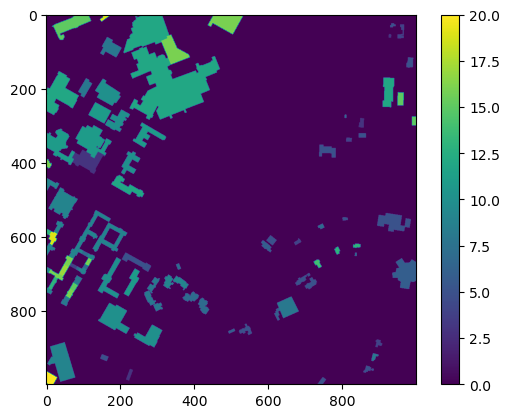

In [10]:
import matplotlib.pyplot as plt 

plt.imshow(np.load('npy/pci_EF_new.npy'))
plt.colorbar()

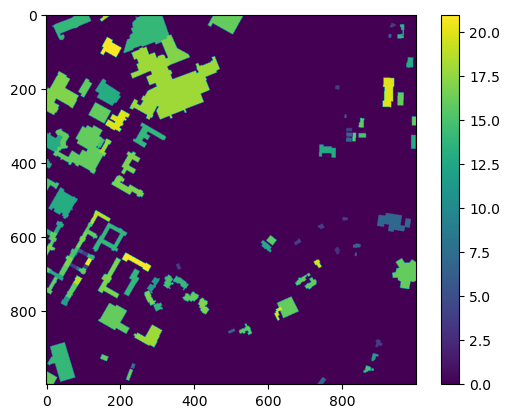

In [11]:
import matplotlib.pyplot as plt 
plt.imshow(np.load('npy/pci_EF.npy'))
plt.colorbar()